In [1]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [13]:
with open('./graphs.pkl', 'rb') as f:
    graphs = pickle.load(f)

In [245]:
df, embeds = get_dataframe(graphs)
# # save df to pickle
# with open('./df.pkl', 'wb') as f:
#     pickle.dump(df, f)
# 
# # save embeddings to pickle
# with open('./embeds.pkl', 'wb') as f:
#     pickle.dump(embeds, f)

In [246]:
df.head()

,node_type,event_date,article_count,prediction,graph_id
node_id,,,,,
e_2765400,event,16517.0,13.0,NaN,0
e_2150458,event,16438.0,31.0,NaN,0
e_1908730,event,16406.0,36.0,NaN,0
e_2794829,event,16523.0,34.0,NaN,0
e_1664256,event,16377.0,22.0,NaN,0


In [6]:
from umap import UMAP

umap = UMAP(n_components=2, n_neighbors=5, min_dist=0.3, metric='cosine')
umap.fit(embeds)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.3, n_neighbors=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: xlabel='umap_x', ylabel='umap_y'>

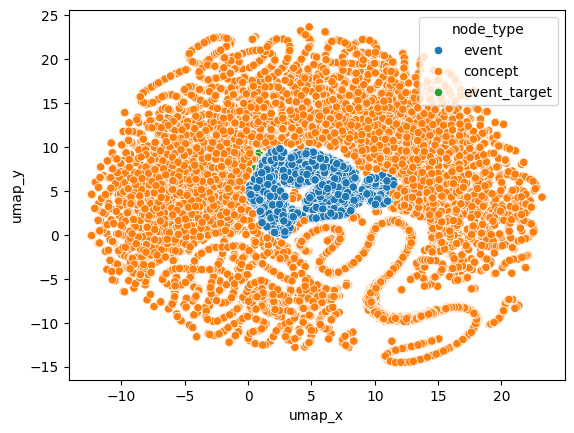

In [12]:
# plot umap
# plot 'event_target' nodes with red, event nodes with blue and concept nodes with green 
import seaborn as sns

df['umap_x'] = umap.embedding_[:, 0]
df['umap_y'] = umap.embedding_[:, 1]

sns.scatterplot(x='umap_x', y='umap_y', hue='node_type', data=df)



In [247]:
df.head()

,node_type,event_date,article_count,prediction,graph_id
node_id,,,,,
e_2765400,event,16517.0,13.0,NaN,0
e_2150458,event,16438.0,31.0,NaN,0
e_1908730,event,16406.0,36.0,NaN,0
e_2794829,event,16523.0,34.0,NaN,0
e_1664256,event,16377.0,22.0,NaN,0


In [248]:
targets = df[df['node_type'] == 'event_target']

In [249]:
targets.shape

(1536, 5)

In [250]:
# round predictions
targets['prediction'] = targets['prediction'].apply(lambda x: round(x))


/var/folders/t_/181rjdy93vg4rlj82l3c36_40000gn/T/ipykernel_75570/3015946293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets['prediction'] = targets['prediction'].apply(lambda x: round(x))


In [251]:
def get_class(value):
    # if value <= 9:
    #     return 'low'
    if value <= 21:
        return 'low'
    else:
        return 'high'

In [252]:
targets['class'] = targets['article_count'].apply(lambda x: get_class(x))
targets['prediction_class'] = targets['prediction'].apply(lambda x: get_class(x))
# add an L1 column
targets['l1'] = targets.apply(lambda x: abs(x['article_count'] - x['prediction']), axis=1)
targets['mape'] = targets.apply(lambda x: abs((x['article_count'] - x['prediction']) / x['article_count']), axis=1)

/var/folders/t_/181rjdy93vg4rlj82l3c36_40000gn/T/ipykernel_75570/1889647829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets['class'] = targets['article_count'].apply(lambda x: get_class(x))
/var/folders/t_/181rjdy93vg4rlj82l3c36_40000gn/T/ipykernel_75570/1889647829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets['prediction_class'] = targets['prediction'].apply(lambda x: get_class(x))
/var/folders/t_/181rjdy93vg4rlj82l3c36_40000gn/T/ipykernel_75570/1889647829.py:4: SettingWithCopyWar

In [253]:
from sklearn.metrics import confusion_matrix, classification_report

In [254]:
confusion_matrix(targets['class'], targets['prediction_class'])

array([[245, 365],
       [ 93, 833]])

In [255]:
print(classification_report(targets['class'], targets['prediction_class']))

              precision    recall  f1-score   support

        high       0.72      0.40      0.52       610
         low       0.70      0.90      0.78       926

    accuracy                           0.70      1536
   macro avg       0.71      0.65      0.65      1536
weighted avg       0.71      0.70      0.68      1536


In [256]:
# get l1, mape and mse for each class
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_metrics(y_true, y_pred):
    l1 = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mse = mean_squared_error(y_true, y_pred)
    
    print(f'L1: {l1}')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    

In [257]:
# get metrics for each class

print('low')
low = targets[targets['class'] == 'low']
get_metrics(low['article_count'], low['prediction'])

# print('medium')
# medium = targets[targets['class'] == 'medium']
# get_metrics(medium['article_count'], medium['prediction'])

print('high')
high = targets[targets['class'] == 'high']
get_metrics(high['article_count'], high['prediction'])


low
L1: 7.82829373650108
MAPE: 85.56504085772922
MSE: 238.30777537796976
high
L1: 53.0311475409836
MAPE: 74.62384566629535
MSE: 10194.460655737705


In [309]:
# find a target in 'high' with a good prediction
# sort by l1 asc, then by article_count desc
high.sort_values(by=['article_count', 'l1'], ascending=[False, False]).head(150)

,node_type,event_date,article_count,prediction,graph_id,class,prediction_class,l1,mape
node_id,,,,,,,,,
e_2352220,event_target,16465.0,1180.0,127,0,high,high,1053.0,0.892373
e_2806601,event_target,16520.0,806.0,58,2,high,high,748.0,0.928040
e_2749393,event_target,16517.0,733.0,24,3,high,high,709.0,0.967258
e_2487423,event_target,16477.0,659.0,36,5,high,high,623.0,0.945372
e_2631601,event_target,16499.0,551.0,54,0,high,high,497.0,0.901996
...,...,...,...,...,...,...,...,...,...
e_2809590,event_target,16527.0,72.0,9,4,high,low,63.0,0.875000
e_2843674,event_target,16542.0,72.0,21,2,high,low,51.0,0.708333
e_2345957,event_target,16469.0,72.0,22,1,high,high,50.0,0.694444


In [306]:
target_node = 'e_2901694'
target_graph = graphs[high['graph_id'].loc[target_node]]

In [321]:
high.loc[target_node]

node_type           event_target
event_date               16580.0
article_count               22.0
prediction                    21
graph_id                       3
class                       high
prediction_class             low
l1                           1.0
mape                    0.045455
Name: e_2901694, dtype: object

In [356]:
# get an ego graph of the target node
target_graph = target_graph.reverse()
ego_graph = nx.ego_graph(target_graph, target_node, radius=5, center=True, undirected=False)
# remove concepts
# ego_graph.remove_nodes_from([n for n in ego_graph.nodes if ego_graph.nodes[n]['node_type'] in ['concept', 'event_target'] and n != target_node])

In [357]:
events = ego_graph.nodes
len(events)

737

In [358]:
target_value = ego_graph.nodes[target_node]['node_target'][0]
node_counts = {}
for node, data in ego_graph.nodes(data=True):
    if data['node_type'] == 'event_target':
        node_counts[node] = 0
    else:
        val = data['node_feature'][0]
        node_counts[node] = abs(round(val) - target_value)

In [359]:
len(node_counts)

737

In [360]:
# get embeddings of events
event_embeddings = []
for event in events:
    event_embeddings.append(ego_graph.nodes[event]['embedding'])

In [361]:
# get umap of event embeddings
event_umap = UMAP(n_components=2, n_neighbors=5, min_dist=1, metric='cosine')
event_umap.fit(event_embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=1, n_neighbors=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

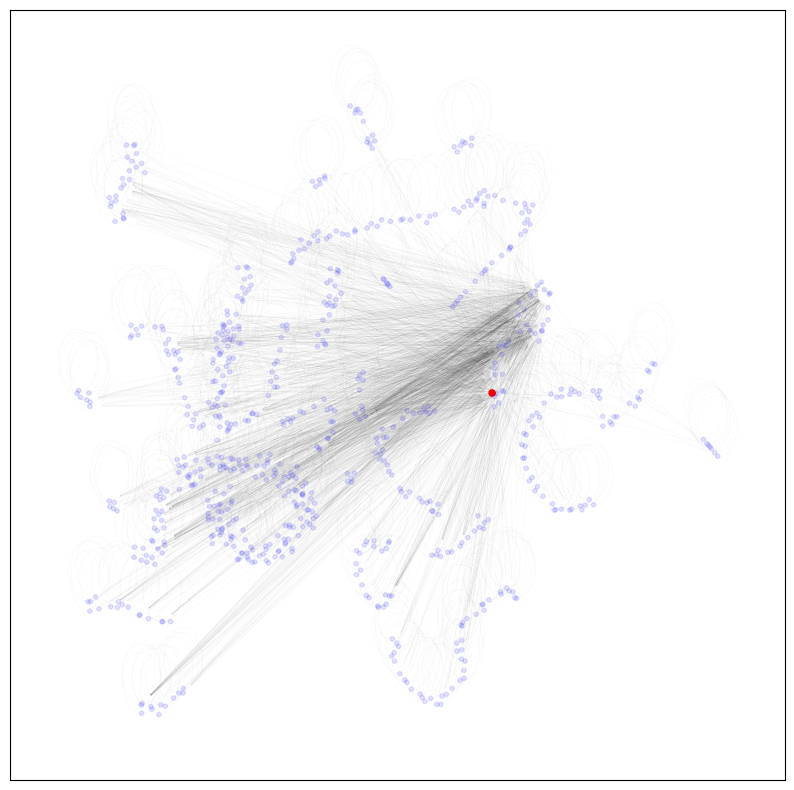

In [362]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(10, 10))

# Assuming event_umap.embedding_ contains your UMAP coordinates
event_umap_x = event_umap.embedding_[:, 0]
event_umap_y = event_umap.embedding_[:, 1]

# Assuming ego_graph is your NetworkX graph and target_node is defined
node_types = [ego_graph.nodes[node]['node_type'] for node in ego_graph.nodes]

# Determine node colors and sizes
node_values = []
node_sizes = []
alphas = []
for node in ego_graph.nodes:
    if node == target_node:
        node_values.append('red')  # Red for target node
        node_sizes.append(20)     # Larger size for target node
        alphas.append(1.0)        # No transparency for target node
    else:
        node_values.append('blue') # Blue for other nodes
        node_sizes.append(10)      # Default size for other nodes
        alphas.append(0.1)        # Low transparency for other nodes

# Create a position dictionary for NetworkX nodes based on UMAP coordinates
pos = {node: (x, y) for node, x, y in zip(ego_graph.nodes, event_umap_x, event_umap_y)}

# Draw nodes
nx.draw_networkx_nodes(ego_graph, pos, node_color=node_values, node_size=node_sizes, alpha=alphas)

# Draw edges with smaller arrows
nx.draw_networkx_edges(ego_graph, pos, edge_color='black', arrowsize=0.1, width=0.01)

# Optionally, draw node labels
# nx.draw_networkx_labels(ego_graph, pos)

# Show the plot
plt.show()


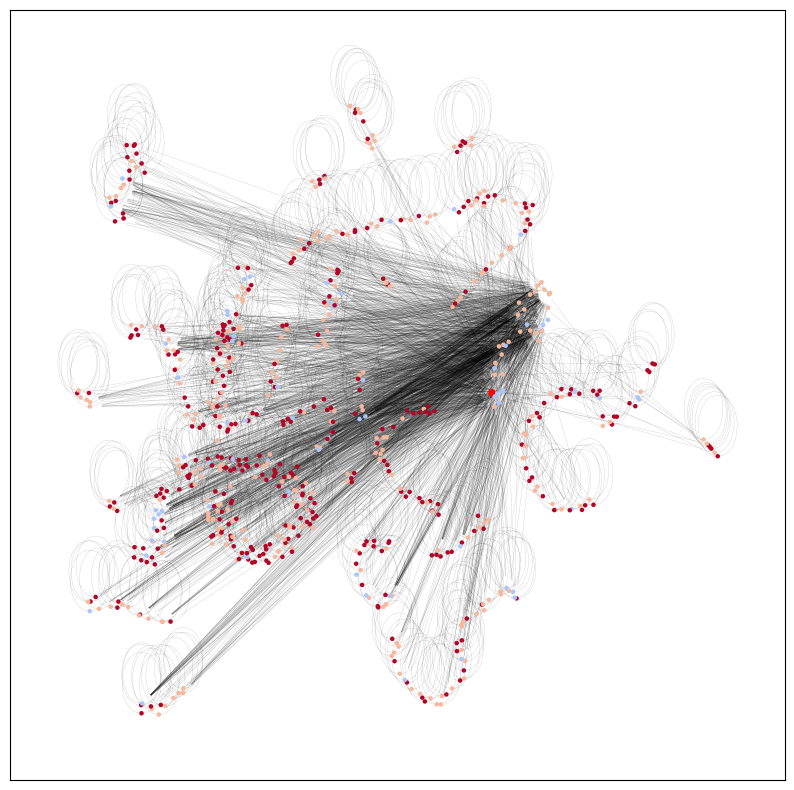

In [363]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

plt.figure(figsize=(10, 10))

# Assuming event_umap.embedding_ contains your UMAP coordinates
event_umap_x = event_umap.embedding_[:, 0]
event_umap_y = event_umap.embedding_[:, 1]

# Assuming ego_graph is your NetworkX graph and target_node is defined
node_types = [ego_graph.nodes[node]['node_type'] for node in ego_graph.nodes]

undirected_ego = ego_graph.to_undirected()

# Compute shortest path lengths from the target node
path_lengths = nx.single_source_shortest_path_length(undirected_ego, target_node)

# Use a colormap to assign colors based on distance
cmap = plt.get_cmap('coolwarm')

# Determine node colors and sizes
node_values = []
node_sizes = []
max_distance = max(path_lengths.values()) if path_lengths else 1  # Avoid division by zero

for node in ego_graph.nodes:
    if node == target_node:
        node_values.append('red')    # Red for target node
        node_sizes.append(20)        # Larger size for target node
    else:
        # Use a default large distance for nodes not connected to the target_node
        distance = path_lengths.get(node, max_distance)
        node_values.append(cmap(distance / max_distance))  # Map the distance to a color
        node_sizes.append(5)         # Default size for other nodes

# Create a position dictionary for NetworkX nodes based on UMAP coordinates
pos = {node: (x, y) for node, x, y in zip(ego_graph.nodes, event_umap_x, event_umap_y)}

# Draw nodes
nx.draw_networkx_nodes(ego_graph, pos, node_color=node_values, node_size=node_sizes)

# Draw edges with smaller arrows
nx.draw_networkx_edges(ego_graph, pos, edge_color='black', arrowsize=0.01, width=0.05)

# Optionally, draw node labels
# nx.draw_networkx_labels(ego_graph, pos)

# Show the plot
plt.show()


In [364]:
target_value = ego_graph.nodes[target_node]['node_target'][0]
node_counts = {}
for node, data in ego_graph.nodes(data=True):
    if data['node_type'] == 'event_target':
        node_counts[node] = -1
    else:
        val = data['node_feature'][0]
        node_counts[node] = abs(round(val) - target_value)

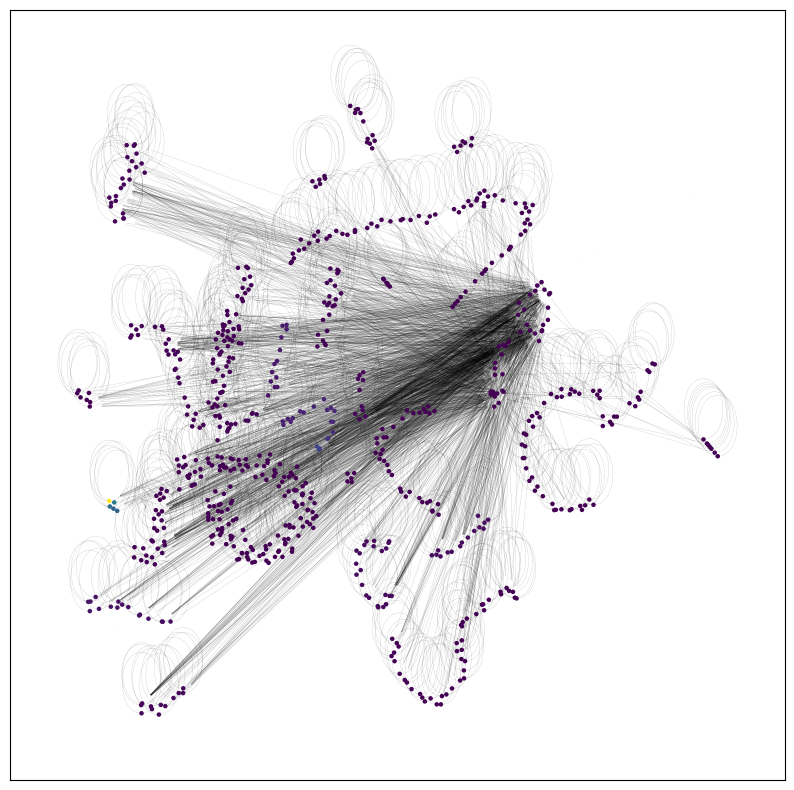

In [365]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

plt.figure(figsize=(10, 10))

# Assuming event_umap.embedding_ contains your UMAP coordinates
event_umap_x = event_umap.embedding_[:, 0]
event_umap_y = event_umap.embedding_[:, 1]

# Assuming ego_graph is your NetworkX graph and target_node is defined
node_types = [ego_graph.nodes[node]['node_type'] for node in ego_graph.nodes]

# Assuming you have a dictionary mapping node_id to a number
# For example: node_values = {node_id1: value1, node_id2: value2, ...}
target_value = ego_graph.nodes[target_node]['node_target'][0]
# Determine node colors and sizes
node_sizes = []
node_values = []
for node in ego_graph.nodes:
    if node == target_node:
        node_values.append(0)    # Red for target node
        node_sizes.append(20)        # Larger size for target node
    else:
        value = node_counts[node]
        node_values.append(value)  # Map the value to a color
        node_sizes.append(5)         # Default size for other nodes

# normalize node values
node_values = np.array(node_values)
node_values = node_values / node_values.max()

# map node values to a color map
cmap = plt.get_cmap('viridis')
node_colors = [cmap(value) if value >= 0 else 'red' for value in node_values]

# Create a position dictionary for NetworkX nodes based on UMAP coordinates
pos = {node: (x, y) for node, x, y in zip(ego_graph.nodes, event_umap_x, event_umap_y)}

# Draw nodes
nx.draw_networkx_nodes(ego_graph, pos, node_color=node_colors, node_size=node_sizes)

# Draw edges with smaller arrows
nx.draw_networkx_edges(ego_graph, pos, edge_color='black', arrowsize=0.01, width=0.05)

# Optionally, draw node labels
# nx.draw_networkx_labels(ego_graph, pos)

# Show the plot
plt.show()
